ADF Statistic: -1.3840594268117663
p-value: 0.5898939234402516
The time series is not stationary. Differencing might be required.


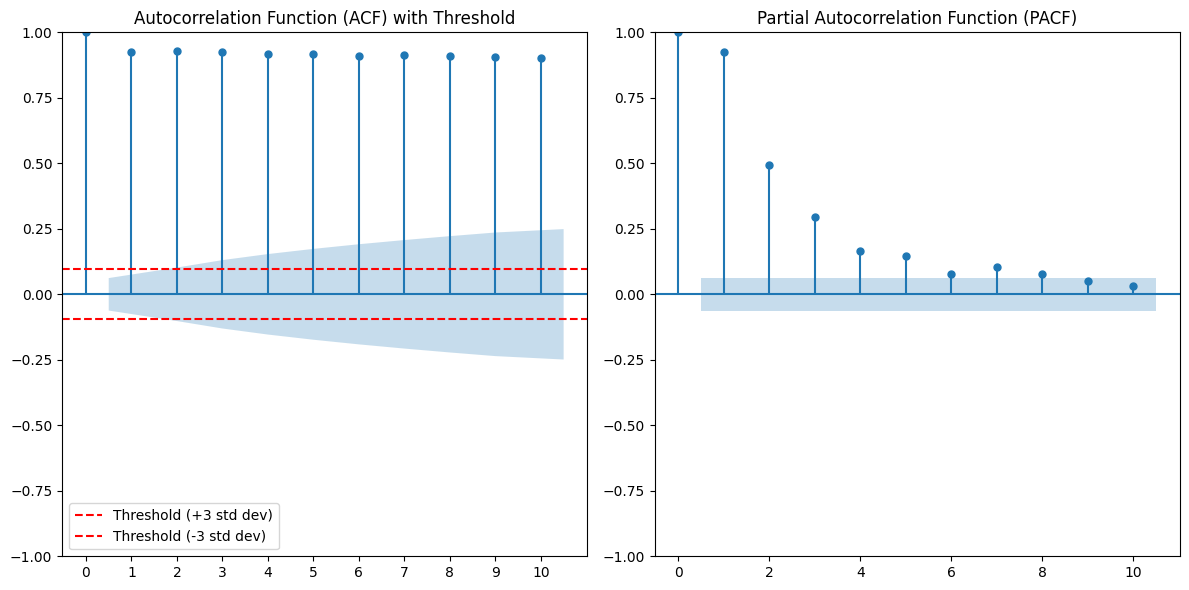

/opt/anaconda3/envs/SEAS6414/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


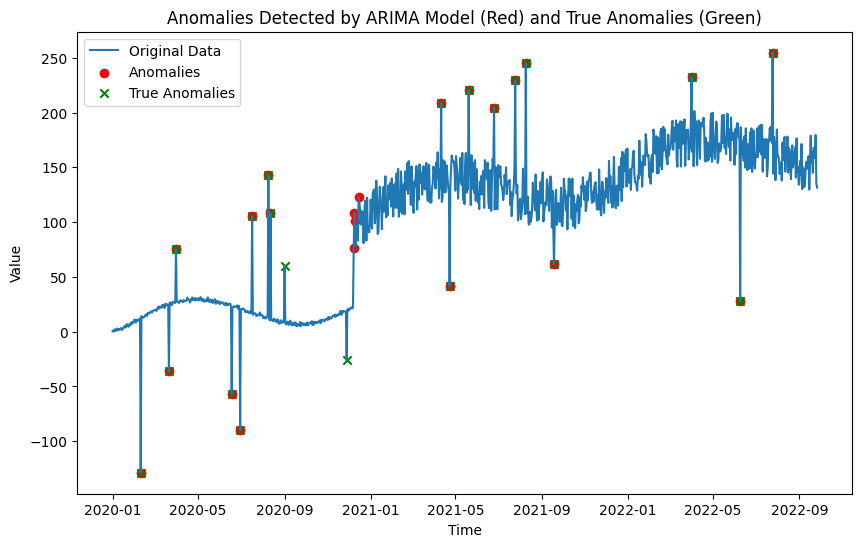

Anomalies detected at indices: [40, 80, 90, 169, 181, 198, 221, 224, 342, 343, 344, 349, 466, 478, 505, 541, 571, 586, 626, 821, 890, 936]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Generate synthetic data with trend, seasonality, lags, and anomalies
np.random.seed(42)
n_points = 1000
t = np.arange(n_points)
trend = 0.05 * t
seasonality = 10 * np.sin(2 * np.pi * t / 365)
noise = np.random.normal(0, 1, size=n_points)
data = trend + seasonality + noise

# Add lag structure (autoregressive process)
lag = 10
for i in range(lag, n_points):
    data[i] += 0.5 * data[i - lag]

# Add anomalies (spikes/drops)
num_anomalies = 20
anomaly_indices = np.random.choice(range(n_points), num_anomalies, replace=False)
for idx in anomaly_indices:
    anomaly_type = np.random.choice(['spike', 'drop'])
    if anomaly_type == 'spike':
        data[idx] += np.random.uniform(30, 150)
    else:
        data[idx] -= np.random.uniform(30, 150)

# Add a lag-break anomaly (a sudden spike)
anomaly_point = np.random.randint(300, 700)
data[anomaly_point:] += np.random.uniform(50, 100, size=n_points - anomaly_point)

# Create DataFrame
df = pd.DataFrame({'timestamp': pd.date_range(start='2020-01-01', periods=n_points, freq='D'),
                   'value': data})

# ADF Test for Stationarity
adf_result = adfuller(df['value'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Differencing might be required.")

# Plot ACF and PACF to help determine ARIMA parameters (focus on first 10 lags)
plt.figure(figsize=(12, 6))

# ACF Plot focusing on the relevant area (showing threshold at 3 standard deviations)
plt.subplot(121)
plot_acf(df['value'], lags=100, ax=plt.gca())  # Set lags to 10
plt.axhline(y=3/np.sqrt(len(df['value'])), color='r', linestyle='--', label="Threshold (+3 std dev)")
plt.axhline(y=-3/np.sqrt(len(df['value'])), color='r', linestyle='--', label="Threshold (-3 std dev)")
plt.title('Autocorrelation Function (ACF) with Threshold')

# Set x-ticks to be integers (from 0 to 10)
plt.xticks(np.arange(0, 11, 1))  # Set the x-ticks to be integers

plt.legend()

# PACF Plot (focus on first 10 lags)
plt.subplot(122)
plot_pacf(df['value'], lags=10, ax=plt.gca())  # Set lags to 10
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# Fit ARIMA Model (p, d, q) where p and q are determined from PACF and ACF
# Based on ACF and PACF plots, let's assume p=6, d=2 (for differencing), q=10
model = ARIMA(df['value'], order=(8, 1, 50))
model_fit = model.fit()

# Anomaly Detection using ARIMA model
# Predicting the values
predictions = model_fit.predict(start=0, end=n_points-1)

# Calculate the residuals (difference between actual and predicted values)
residuals = df['value'] - predictions

# Anomalies are those where the residual is significantly different from 0 (thresholding)
threshold = 2.5 * np.std(residuals)  # 2.5 standard deviations as threshold
anomalies = residuals[abs(residuals) > threshold]

# Plot the time series and highlight anomalies
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['value'], label='Original Data')

# Highlight anomalies with red dots
plt.scatter(df['timestamp'][anomalies.index], df['value'][anomalies.index], color='red', label='Anomalies')

# Highlight true anomalies (from synthetic data)
plt.scatter(df['timestamp'][anomaly_indices], df['value'][anomaly_indices], color='green', label='True Anomalies', marker='x')

plt.title('Anomalies Detected by ARIMA Model (Red) and True Anomalies (Green)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print anomalies
print(f"Anomalies detected at indices: {anomalies.index.tolist()}")


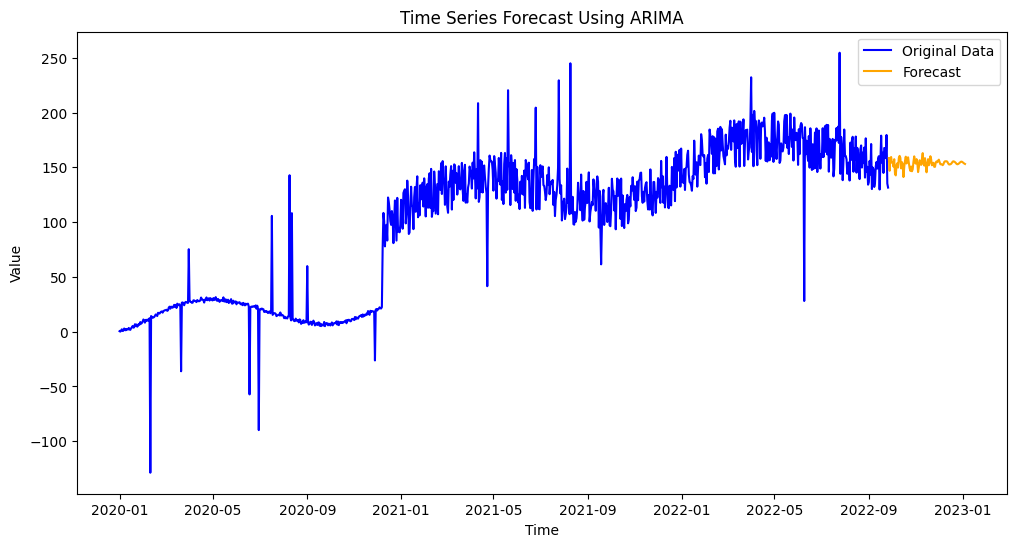

In [5]:
# Forecast future values
forecast_horizon = 100  # Number of days to forecast
forecast = model_fit.forecast(steps=forecast_horizon)
forecast_index = pd.date_range(start=df['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

# Plot original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Original Data', color='blue')
plt.plot(forecast_index, forecast, label='Forecast', color='orange')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecast Using ARIMA')
plt.legend()
plt.show()

/opt/anaconda3/envs/SEAS6414/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/SEAS6414/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 13.538734312185
Mean Squared Error (MSE): 353.94298535304296
Root Mean Squared Error (RMSE): 18.813372514066767


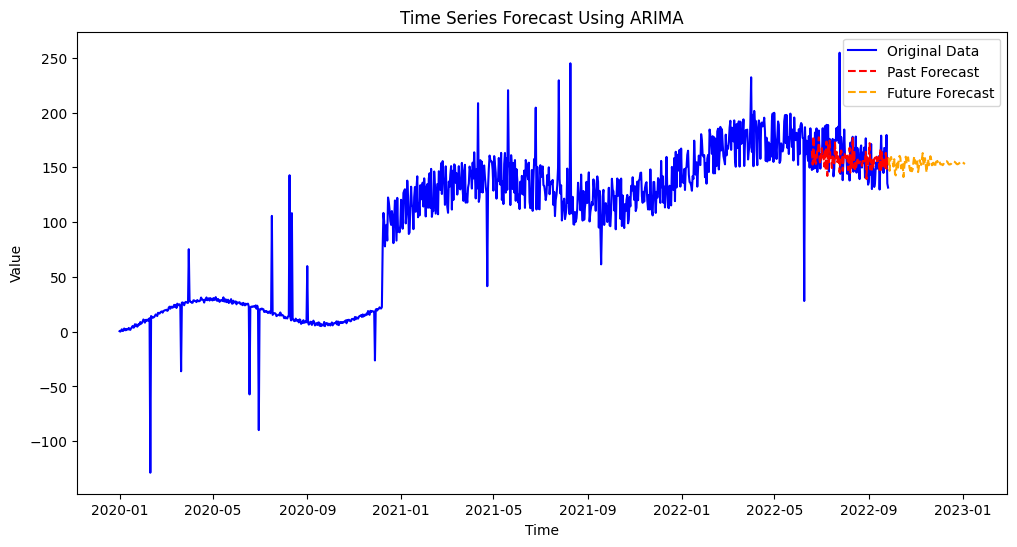

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate forecast on the last 100 days
train_data = df['value'][:-forecast_horizon]
test_data = df['value'][-forecast_horizon:]
model_past = ARIMA(train_data, order=(8, 1, 100))
model_past_fit = model_past.fit()
past_forecast = model_past_fit.forecast(steps=forecast_horizon)

# Calculate error metrics
mae = mean_absolute_error(test_data, past_forecast)
mse = mean_squared_error(test_data, past_forecast)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot original data, test data, and past forecast
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Original Data', color='blue')
plt.plot(df['timestamp'][-forecast_horizon:], past_forecast, label='Past Forecast', color='red', linestyle='dashed')
plt.plot(forecast_index, forecast, label='Future Forecast', color='orange', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecast Using ARIMA')
plt.legend()
plt.show()